In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import re

# Load the job descriptions CSV and classification CSV (replace with the actual file paths)
job_desc_file = 'hugo_boss_merged_output.csv'
class_file = 'classified_paragraphs.csv'

# Read the CSV files
df = pd.read_csv(job_desc_file)
classification_df = pd.read_csv(class_file)

# Clean the "Job Details" column in job description and clean classification_df column names
df['Job Details'] = df['Job Details'].str.replace('\r\n', ' ').str.strip()
classification_df.columns = classification_df.columns.str.lower().str.strip()

# Split job details into sentences/paragraphs and count the frequency
all_paragraphs = []
for details in df['Job Details']:
    paragraphs = re.split(r'[.!\n]', details)
    paragraphs = [para.strip() for para in paragraphs if para.strip()]  # Remove empty and whitespace-only strings
    all_paragraphs.extend(paragraphs)

# Count the frequency of each unique paragraph
from collections import Counter
paragraph_freq = Counter(all_paragraphs)
paragraph_freq_df = pd.DataFrame(paragraph_freq.items(), columns=['Paragraph', 'Frequency']).sort_values(by='Frequency', ascending=False)




In [22]:
# Filter paragraphs with frequency > 27
filtered_paragraphs_df = paragraph_freq_df[paragraph_freq_df['Frequency'] > 27]

filtered_paragraphs_df.head(20)

,Paragraph,Frequency
13,Unsere integrative Kultur respektiert und schä...,75
14,Wir setzen uns für Chancengleichheit im Einste...,73
85,Our inclusive culture embraces each person’s a...,46
86,We are committed to equal employment opportunity,46
87,And we believe our equitable work environment ...,46
81,"We are committed to environmental, animal and ...",43
82,Does innovation drive you? Same for us,43
83,We have digitized most of our workflows and al...,43
156,Wir sind ein globales Unternehmen und unsere M...,43
204,Exclusive discounts for shopping and arts: ben...,42


c:\Users\WANG-\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\WANG-\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\WANG-\AppData\Local\Temp\ipykernel_6028\2549930680.py:66: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(colors))


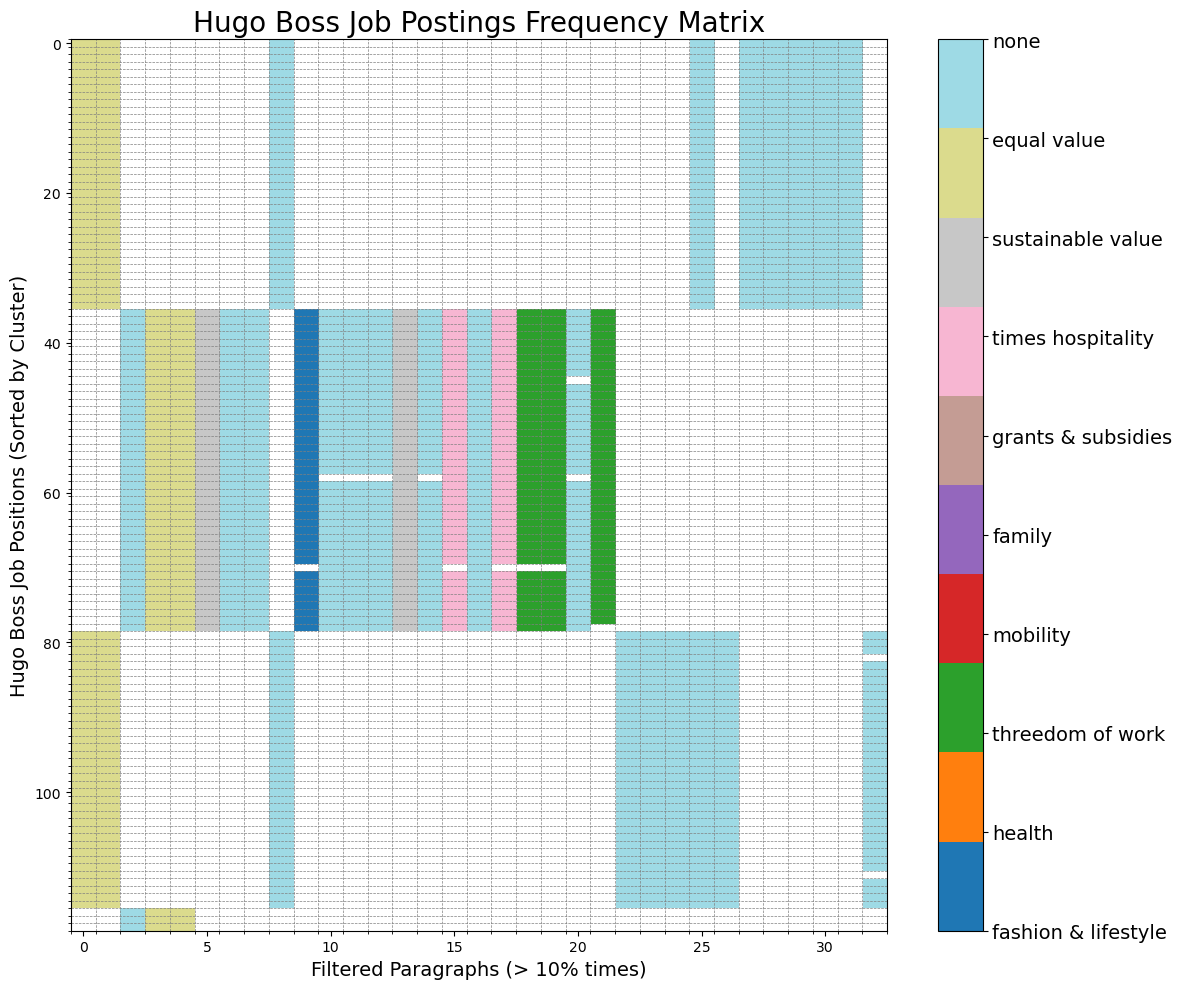

In [23]:


# Clean and synchronize column names for filtered_paragraphs_df
filtered_paragraphs_df.columns = filtered_paragraphs_df.columns.str.lower().str.strip()

# Merge filtered_paragraphs_df with classification_df again, ensuring all columns from classification_df are kept
merged_df = pd.merge(filtered_paragraphs_df, classification_df, on="paragraph", how="left")

# Convert all classification columns to boolean to ensure consistency
for col in classification_df.columns[1:]:
    classification_df[col] = classification_df[col].astype(bool)

# Define colors for each classification and gray for all False
colors = {

    'fashion & lifestyle': 'red',
    'health': 'green',
    'threedom of work': 'blue',
    'mobility': 'purple',
    'family': 'black',
    'grants & subsidies': 'pink',
    'times hospitality': 'yellow',
    'sustainable value': 'orange',
    'equal value': 'cyan',
    'none': 'gray'
}

# Create the matrix for the heatmap with NaN values for missing paragraphs
filtered_job_paragraphs_matrix_with_nan = np.full((len(df), len(merged_df)), np.nan)

for i, details in enumerate(df['Job Details']):
    for j, paragraph in enumerate(merged_df['paragraph']):
        if paragraph in details:
            row = merged_df.iloc[j]
            class_color = colors['none']  # Default color (gray) if all False
            for class_col in classification_df.columns[1:]:
                if row[class_col]:  # Check for True values in classification columns
                    class_color = colors[class_col]
                    break
            filtered_job_paragraphs_matrix_with_nan[i, j] = list(colors.values()).index(class_color)

# Apply KMeans clustering to the job descriptions based on the paragraph occurrences
kmeans = KMeans(n_clusters=4, random_state=42)
job_clusters = kmeans.fit_predict(np.nan_to_num(filtered_job_paragraphs_matrix_with_nan))  # Convert NaN to 0 for clustering

# Add the cluster labels to the dataframe for sorting
df['Cluster'] = job_clusters

# Sort the job descriptions based on their assigned cluster
sorted_df = df.sort_values(by='Cluster').reset_index(drop=True)

# Recreate the matrix for the heatmap, sorted by clusters
sorted_job_paragraphs_matrix_with_nan = np.full((len(sorted_df), len(merged_df)), np.nan)

for i, details in enumerate(sorted_df['Job Details']):
    for j, paragraph in enumerate(merged_df['paragraph']):
        if paragraph in details:
            row = merged_df.iloc[j]
            class_color = colors['none']  # Default color (gray) if all False
            for class_col in classification_df.columns[1:]:
                if row[class_col]:
                    class_color = colors[class_col]
                    break
            sorted_job_paragraphs_matrix_with_nan[i, j] = list(colors.values()).index(class_color)

# Plot the heatmap with jobs sorted by cluster
plt.figure(figsize=(12, 10))
cmap = plt.cm.get_cmap('tab20', len(colors))
cmap.set_bad(color='white')  # Set white for missing values (NaN)

plt.imshow(sorted_job_paragraphs_matrix_with_nan, cmap=cmap, aspect='auto')

# Create a colorbar with class labels
class_labels_for_colorbar = list(colors.keys())
cbar = plt.colorbar(ticks=np.arange(len(colors)))  # Set ticks to match the number of colors
cbar.ax.set_yticklabels(class_labels_for_colorbar, fontsize=14)

# Set ticks in the middle of the grid squares
ax = plt.gca()
ax.set_xticks(np.arange(-0.5, len(merged_df), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(sorted_df), 1), minor=True)

# Add grid to the heatmap, aligning with minor ticks to create boundaries around each data point
plt.grid(visible=True, color='gray', linestyle='--', linewidth=0.5, which='minor')

# Label the axes
plt.xlabel('Filtered Paragraphs (> 10% times)',fontsize=14)
plt.ylabel('Hugo Boss Job Positions (Sorted by Cluster)',fontsize=14)
plt.title('Hugo Boss Job Postings Frequency Matrix',fontsize=20)

plt.tight_layout()
plt.show()

In [24]:
df.loc[df['Cluster']==0]

,Job Title,Job Info,Job Details,Cluster
22,Mitarbeiter Lagerlogistik Vollzeit | Befristet...,HUGO BOSS AG\r\nGermany\r\nWendlingen\r\nCateg...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0
23,Aushilfe Lagerlogistik Vollzeit | Befristet | ...,HUGO BOSS AG\r\nGermany\r\nWendlingen\r\nCateg...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0
27,Mechatroniker / Servicetechniker Filderstadt (...,HUGO BOSS AG\r\nGermany\r\nFilderstadt\r\nCate...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0
28,Aushilfe Lagerlogistik Vollzeit | Befristet | ...,HUGO BOSS AG\r\nGermany\r\nFilderstadt\r\nCate...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0
36,Ausbildung Industriekaufmann/-Frau Mit Schwerp...,HUGO BOSS AG\r\nGermany\r\nMetzingen\r\nCatego...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0
40,Aushilfe Küche & Service | Befristet (M/W/D),HUGO BOSS AG\r\nGermany\r\nMetzingen\r\nCatego...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0
43,Duales Studium Informatik (B. Sc.),HUGO BOSS AG\r\nGermany\r\nMetzingen\r\nCatego...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0
44,Ausbildung Zum/R Kaufmann/-Frau Im E-Commerce ...,HUGO BOSS AG\r\nGermany\r\nMetzingen\r\nCatego...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0
45,Ausbildung Zum/R Sport- Und Fitnesskaufmann/-F...,HUGO BOSS AG\r\nGermany\r\nMetzingen\r\nCatego...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0
46,Ausbildung Zum Kaufmann Im Einzelhandel Ausbil...,HUGO BOSS AG\r\nGermany\r\nMetzingen\r\nCatego...,"Unsere Vision ist es, HUGO BOSS als die weltwe...",0


In [25]:
# Find the unique clusters from the Hugo Boss data
unique_clusters = sorted_df['Cluster'].unique()

# Create a dictionary to store the list of indices for each cluster
cluster_indices_dict = {}

for cluster in unique_clusters:
    cluster_indices = sorted_df[sorted_df['Cluster'] == cluster].index.tolist()
    cluster_indices_dict[cluster] = cluster_indices

# Output the cluster indices dictionary
cluster_indices_dict

cluster_titles_dict = {}

for cluster, indices in cluster_indices_dict.items():
    cluster_titles = sorted_df.loc[indices, 'Job Title'].tolist()
    cluster_titles_dict[cluster] = cluster_titles

# Output the job titles for each cluster
cluster_titles_dict

# Perform word frequency analysis for each cluster's job titles
cluster_word_freq_dict = {}

for cluster, titles in cluster_titles_dict.items():
    # Combine all job titles for the cluster into one text
    all_titles_text = ' '.join(titles)
    words = re.findall(r'\w+', all_titles_text.lower())  # Extract all words and convert to lowercase
    
    # Count the frequency of each word
    word_freq = Counter(words)
    
    # Convert to DataFrame for easier visualization and analysis
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
    
    # Store the word frequency DataFrame for each cluster
    cluster_word_freq_dict[cluster] = word_freq_df

# Display the top 10 most frequent words for each cluster
for cluster, word_freq_df in cluster_word_freq_dict.items():
    print(f"Cluster {cluster} - Top 20 Most Frequent Words:")
    print(word_freq_df.head(20))
    print("\n")

Cluster 0 - Top 20 Most Frequent Words:
             Word  Frequency
6               m         35
7               w         35
8               d         35
9      ausbildung          8
46         talent          6
47           pool          6
29            zum          5
18      befristet          5
81       vollzeit          4
15       aushilfe          4
13    schwerpunkt          4
41      praktikum          4
80  lagerlogistik          4
12            mit          3
32             im          3
42             it          3
68       logistik          3
31       kaufmann          3
11           frau          3
36      wholesale          2


Cluster 1 - Top 20 Most Frequent Words:
          Word  Frequency
7            m         38
9            d         38
8            f         37
0   internship         22
1       global         12
10        boss         12
17      design          8
2    marketing          7
31  management          7
49          it          6
25    menswear         